In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')
import numpy as np
from pysurvival.models import BaseModel
from pysurvival import utils
import scipy
import pandas as pandas
import copy
import random
from sklearn.preprocessing import StandardScaler
from source.utils import create_correlated_var
from pysurvival.models.simulations import SimulationModel
from lifelines import CoxPHFitter
import pandas as pd

In [5]:
import networkx as nx
from cga import cga
from itertools import cycle
import tqdm as tqdm

In [6]:
from sklearn.model_selection import train_test_split

## Helper Functions

In [7]:
def _sample_random_data(N):
    """
    Generating a array of size N from a random distribution -- the available
    """
    index = np.random.binomial(n = 4, p = 0.5)
    distributions = {
        'binomial_a': np.random.binomial(n = 20, p = 0.6, size = N ),
        'binomial_b': np.random.binomial(n = 200, p = 0.6, size = N ),
        'chisquare': np.random.chisquare(df = 10, size = N ),
        'exponential_a': np.random.exponential(scale=0.1, size = N ),
        'exponential_b': np.random.exponential(scale=0.01, size = N ),
        'gamma': np.random.gamma(shape=2., scale=2., size = N ),
        'normal_a': np.random.normal(loc=-1.0, scale=5.0, size=N ),
        'normal_b': np.random.normal(loc=10.0, scale=10.0, size=N ),
        'uniform_a': np.random.uniform(low=-2.0, high=10.0, size=N ),
        'uniform_b': np.random.uniform(low=-20.0, high=100.0, size=N ),
        'laplace': np.random.laplace(loc=0.0, scale=1.0, size=N )
    }

    list_distributions = copy.deepcopy(list(distributions.keys()))
    random.shuffle(list_distributions)
    key = list_distributions[ index ]
    return key, distributions[key]

def fit_coxph(df):
    cph = CoxPHFitter()
    cph.fit(df, 'time', 'event')
    cph.print_summary()

def fit_coxph_norm(df):
    standard_scaler = StandardScaler()
    for col in df.columns:
        if col == 'time' or col == 'event':
            pass
        df[col] = standard_scaler.fit_transform(df[[col]])
    cph = CoxPHFitter()
    cph.fit(df, 'time', 'event')
    cph.print_summary()

## Simulation Model with correlations

In [35]:
class SimulationModelWithCorrelations(SimulationModel):
    """
    Subclasses `SimulationModel` to generated data from an predefined
    risk factor.
    """

    def generate_data(self,
                      df: pd.DataFrame,
                      feature_weights: list,
                      feature_names: list,
                      ):

        def risk_function(x_std, feature_weights):
            """ Calculating the risk function based on the given risk type """

            # Dot product
            risk = np.dot(x_std, feature_weights )

            # Choosing the type of risk
            if self.risk_type.lower() == 'linear' :
                return risk.reshape(-1, 1)

            elif self.risk_type.lower() == 'square' :
                risk = np.square(risk*self.risk_parameter)


            elif self.risk_type.lower() == 'gaussian' :
                risk = np.square(risk)
                risk = np.exp( - risk*self.risk_parameter)

            return risk.reshape(-1, 1)

        input_data = df.loc[:, feature_names].to_numpy()
        self.dataset = copy.deepcopy(df)
        num_samples = input_data.shape[0]
        X_std = self.scaler.fit_transform(input_data)
        BX = risk_function(X_std, feature_weights)

        # Building the survival times
        T = self.time_function(BX)
        C = np.random.normal(loc=self.censored_parameter, scale=5, size=num_samples)
        C = np.maximum(C, 0.0)
        time = np.minimum(T, C)
        E = 1.0 * (T == time)

        # Building dataset
        self.dataset = copy.deepcopy(df)
        self.dataset['time'] = time
        self.dataset['event'] = E
        self.dataset['hazard'] = BX

        # Building the time axis and time buckets
        self.times = np.linspace(0.0, max(self.dataset["time"]), self.bins)
        self.get_time_buckets()

        # Building baseline functions
        self.baseline_hazard = self.hazard_function(self.times, 0)
        self.baseline_survival = self.survival_function(self.times, 0)

        # Printing summary message
        message_to_print = "Number of data-points: {} - Number of events: {}"
        print(message_to_print.format(num_samples, sum(E)))
        return self.dataset

## Correlation Case Graph

In [42]:
@cga.node
def correlate(x: float, rnorm_vector:float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = create_correlated_var(x, rnorm_vector, mu=np.mean(x), sd=np.std(x), empirical=True, r=-0.8)
    return correlate + noise

@cga.node
def sample_random_normal(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.normal(size=10) + noise

@cga.node
def correlation_coefficient(coeff:float) -> float:
    return coeff

class CorrelationCaseGraph(cga.Graph):
    def __init__(self):
        """
        causal graph for correlation case
        :param n: number of data points
        :param coeff: desired correlation coefficient between the two variables
        """
        noise = cga.node(lambda: np.random.normal(scale=0.0001, size=10))
        rnorm_vector = cga.node(lambda: np.random.normal(size=10))
        self.rnorm_vector = rnorm_vector(name="rnorm")
        self.noise_x = noise(name="noise_x")
        self.noise_y = noise(name="noise_y")
        self.x = sample_random_normal(self.noise_x, name='x')
        self.y = correlate(self.x, self.rnorm_vector, self.noise_y, name='y')
        super().__init__([self.x, self.y])

    def get_interventions(self,
                          sim: SimulationModelWithCorrelations,
                          n_samples: int,
                          feature_weights: list,
                          ) -> pd.DataFrame:
        data = None
        for node in [self.noise_x, self.noise_y]:
            for _ in tqdm.auto.trange(n_samples, desc=f"Intervention {node.name}"):
                # resample noise
                orig, intervention = self.sample_do(action=cga.Resample(node))
                row = {'modified_attribute': [node.name] * 10}
                # add orig + do to the dictionary
                row.update({
                    n.name + "_orig": v
                    for n, v in orig.items()
                })
                row.update({
                    n.name + "_do": v
                    for n, v in intervention.items()
                })

                data = row if data is None else data
                for key in row.keys():
                    row[key] = row[key].tolist() if isinstance(row[key], np.ndarray) else row[key]
                    data[key].extend(row[key])
        df = pd.DataFrame(data)

        orig_cols = ['x_orig', 'y_orig']
        orig_df = sim.generate_data(df, feature_names=orig_cols,
                                    feature_weights=feature_weights)
        df['event_orig'] = orig_df.event
        df['time_orig'] = orig_df.time
        df['hazard_orig'] = orig_df.hazard

        do_cols = ['x_do', 'y_do']
        do_df = sim.generate_data(df, feature_names=do_cols,
                                  feature_weights=feature_weights)
        df['event_do'] = do_df.event
        df['time_do'] = do_df.time
        df['hazard_do'] = do_df.hazard
        return df

## Simulation Model

In [16]:
import networkx
import matplotlib.pyplot as plt

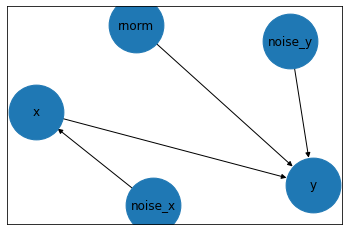

In [37]:
correlation_graph = CorrelationCaseGraph()
gnx = correlation_graph.to_networkx()
nx.draw_networkx(
    gnx,
    labels={n: n.name for n in gnx.nodes},
    pos=nx.layout.spring_layout(gnx, k=8),
    node_size=3_000,
)
plt.show()

In [1]:
correlation_graph = CorrelationCaseGraph()
feature_weights = [np.log(2), np.log(1.5)]
sim = SimulationModelWithCorrelations(risk_type='linear', alpha=1.0, beta=5.0, censored_parameter=5.0, survival_distribution='weibull')
df = correlation_graph.get_interventions(sim=sim, n_samples=2000, feature_weights=feature_weights)

NameError: name 'CorrelationCaseGraph' is not defined

In [44]:
df.corr()

,noise_x_orig,x_orig,rnorm_orig,noise_y_orig,y_orig,noise_x_do,x_do,rnorm_do,noise_y_do,y_do,event_orig,time_orig,hazard_orig,event_do,time_do,hazard_do
noise_x_orig,1.000000,-0.001386,0.006349,-0.002420,0.009059,0.501467,0.003421,0.006349,-0.011160,0.003749,0.007201,-0.001086,0.004991,-0.004319,-0.009173,0.007149
x_orig,-0.001386,1.000000,0.011415,0.005061,-0.621909,-0.000251,0.500862,0.011415,0.007166,-0.309070,0.010940,-0.162300,0.811529,0.001936,-0.083805,0.407545
rnorm_orig,0.006349,0.011415,1.000000,0.002658,0.473631,0.004301,0.004825,1.000000,-0.002184,0.480016,0.003921,-0.076023,0.367966,-0.001882,-0.077784,0.363677
noise_y_orig,-0.002420,0.005061,0.002658,1.000000,0.001415,0.000976,0.001343,0.002658,0.496602,0.000347,0.008558,0.005855,0.007512,0.007430,0.008802,0.001969
y_orig,0.009059,-0.621909,0.473631,0.001415,1.000000,0.006357,-0.313294,0.473631,-0.005608,0.636759,0.002835,0.012522,-0.047128,0.005376,-0.009039,0.075361
noise_x_do,0.501467,-0.000251,0.004301,0.000976,0.006357,1.000000,0.006665,0.004301,-0.007719,0.000754,0.004348,-0.000168,0.004423,0.005923,0.002285,0.009048
x_do,0.003421,0.500862,0.004825,0.001343,-0.313294,0.006665,1.000000,0.004825,0.003481,-0.620036,0.004356,-0.084411,0.405118,0.016508,-0.151305,0.811481
rnorm_do,0.006349,0.011415,1.000000,0.002658,0.473631,0.004301,0.004825,1.000000,-0.002184,0.480016,0.003921,-0.076023,0.367966,-0.001882,-0.077784,0.363677
noise_y_do,-0.011160,0.007166,-0.002184,0.496602,-0.005608,-0.007719,0.003481,-0.002184,1.000000,-0.006554,0.007614,0.005099,0.004956,0.001372,-0.001781,-0.000449
y_do,0.003749,-0.309070,0.480016,0.000347,0.636759,0.000754,-0.620036,0.480016,-0.006554,1.000000,0.006899,-0.011080,0.080884,-0.004795,0.006397,-0.044660


In [92]:
def df2csv(
        df: pd.DataFrame,
        name: str,
        output_dir: str,
):
    """
    Writes csv given a dataframe + name
    """
    train, valid = train_test_split(df, test_size=0.3)
    train.to_csv(
        f"{output_dir}/{name}_train_details.csv",
        index=False,
    )
    valid.to_csv(
        f"{output_dir}/{name}_valid_details.csv",
        index=False,
    )

    train_df = train.loc[:, ['x_orig', 'correlate_orig', 'time_orig', 'event_orig']]
    valid_df = valid.loc[:, ['x_orig', 'correlate_orig', 'time_orig', 'event_orig']]
    train_df.rename(columns=dict(x_orig='x',
                                 correlate_orig='correlate',
                                 time_orig='time',
                                 event_orig='event'), inplace=True)

    valid_df.rename(columns=dict(x_orig='x',
                                 correlate_orig='correlate',
                                 time_orig='time',
                                 event_orig='event'), inplace=True)
    train_df.to_csv(
        f"{output_dir}/{name}_train.csv",
        index=False,
    )
    valid_df.to_csv(
        f"{output_dir}/{name}_valid.csv",
        index=False,
    )

In [93]:
directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/correlation'
df2csv(df, name='correlation_p-0.62', output_dir=directory)

In [99]:
df.loc[32000]['correlate_do'] + df.loc[32000]['noise_y_do']

-0.3367909986912712

In [98]:
df.loc[32000]['correlate_do']

-0.3367990130802222

<AxesSubplot:xlabel='x_orig', ylabel='correlate_orig'>

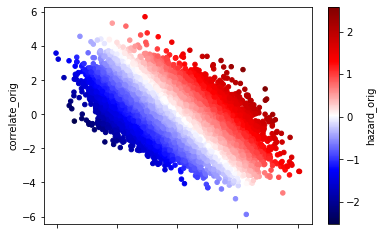

In [16]:
df.plot.scatter('x_orig', 'correlate_orig', c='hazard_orig', colormap='seismic')

<AxesSubplot:xlabel='x_orig', ylabel='hazard_orig'>

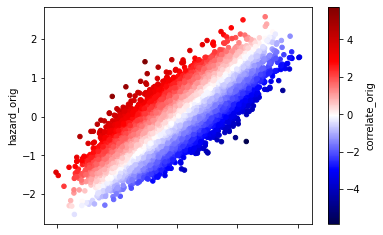

In [17]:
df.plot.scatter('x_orig', 'hazard_orig', c='correlate_orig', colormap='seismic')

<AxesSubplot:xlabel='correlate_orig', ylabel='hazard_orig'>

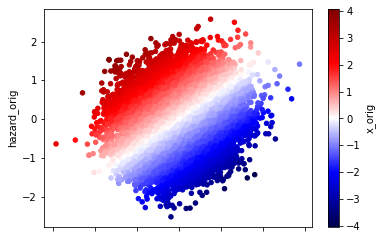

In [18]:
df.plot.scatter('correlate_orig', 'hazard_orig', c='x_orig', colormap='seismic')

In [49]:
train, test = train_test_split(df, test_size=0.3)

In [52]:
train.to_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/correlation/correlation_p-0.61_train_details.csv')
test.to_csv('/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/correlation/correlation_p-0.61_valid_details.csv')

In [53]:
train.corr()

,noise_x_orig,x_orig,noise_y_orig,correlate_orig,noise_x_do,x_do,noise_y_do,correlate_do,event_orig,time_orig,hazard_orig,event_do,time_do,hazard_do
noise_x_orig,1.000000,-0.003570,0.002560,0.010264,0.495898,0.002065,-0.000988,-0.000714,0.000458,-0.004918,0.003075,-0.001234,-0.002808,0.002088
x_orig,-0.003570,1.000000,-0.001958,-0.616356,-0.004938,0.493631,0.012934,-0.309309,0.010525,-0.159819,0.812205,0.010233,-0.070985,0.396377
noise_y_orig,0.002560,-0.001958,1.000000,0.000198,0.003166,-0.002198,0.507898,0.002374,0.009599,0.004609,-0.002338,-0.002794,-0.003436,-0.001026
correlate_orig,0.010264,-0.616356,0.000198,1.000000,0.003589,-0.301794,-0.005613,0.327566,0.000646,0.009700,-0.041221,-0.003580,0.017113,-0.139539
noise_x_do,0.495898,-0.004938,0.003166,0.003589,1.000000,0.000474,-0.000402,0.001744,0.001701,0.004280,-0.003607,-0.001118,-0.005928,0.001895
x_do,0.002065,0.493631,-0.002198,-0.301794,0.000474,1.000000,0.012611,-0.615741,0.017573,-0.071330,0.402751,0.010622,-0.162063,0.811044
noise_y_do,-0.000988,0.012934,0.507898,-0.005613,-0.000402,0.012611,1.000000,-0.003282,0.006465,-0.002500,0.012252,0.000062,0.000197,0.013557
correlate_do,-0.000714,-0.309309,0.002374,0.327566,0.001744,-0.615741,-0.003282,1.000000,-0.013777,0.015406,-0.149787,-0.003365,0.006251,-0.038454
event_orig,0.000458,0.010525,0.009599,0.000646,0.001701,0.017573,0.006465,-0.013777,1.000000,0.806700,0.013832,0.000284,0.001132,0.012057
time_orig,-0.004918,-0.159819,0.004609,0.009700,0.004280,-0.071330,-0.002500,0.015406,0.806700,1.000000,-0.195594,-0.008887,0.013675,-0.079022


In [55]:
train_set = train.loc[:, ['x_orig', 'correlate_orig', 'event_orig', 'time_orig']]

In [60]:
directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/simpson'

train_details = pd.read_csv(f'{directory}/simpsons_resampling_train_details.csv')
train = pd.read_csv(f'{directory}/simpsons_resampling_train.csv')

In [32]:
directory = '/data/analysis/ag-reils/ag-reils-shared/cardioRS/data/interpretability/correlation'
valid = pd.read_csv(f'{directory}/correlation_p-0.62_valid.csv')

In [34]:
valid.isnull().values.any()

False

In [10]:
train.corr()

,x,correlate,time,event
x,1.000000,-0.619733,-0.162864,0.006369
correlate,-0.619733,1.000000,0.009241,-0.004671
time,-0.162864,0.009241,1.000000,0.804038
event,0.006369,-0.004671,0.804038,1.000000


In [11]:
fit_coxph(train)

<lifelines.CoxPHFitter: fitted with 28007 total observations, 5811 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 28007
number of events observed = 22196
   partial log-likelihood = -197722.47
         time fit was run = 2021-11-29 10:19:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x           0.68       1.97       0.01             0.66             0.69                 1.93                 2.00
correlate   0.39       1.47       0.01             0.37             0.40                 1.45                 1.50

              z      p   -log2(p)
covariate                        
x         71.02 <0.005        inf
correlate 43.81 <0.005        inf
---
Concordance = 0.64
Partial AIC = 395448.94
log-likelihood ratio test = 5103.13 on 2 df
-log2(p) of ll-ratio test = inf

In [13]:
fit_coxph_norm(train)

<lifelines.CoxPHFitter: fitted with 28007 total observations, 0 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 28007
number of events observed = 28007
   partial log-likelihood = -256813.37
         time fit was run = 2021-11-29 10:20:11 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x           0.52       1.68       0.01             0.50             0.54                 1.65                 1.71
correlate   0.30       1.35       0.01             0.29             0.32                 1.33                 1.37

              z      p   -log2(p)
covariate                        
x         62.77 <0.005        inf
correlate 38.40 <0.005        inf
---
Concordance = 0.59
Partial AIC = 513630.75
log-likelihood ratio test = 3966.44 on 2 df
-log2(p) of ll-ratio test = inf

In [14]:
import torch.nn as nn
nn.SiLU

torch.nn.modules.activation.SiLU

In [16]:
!which python

/data/analysis/ag-reils/ruyogagp/envs/new/bin/python


In [18]:
from pytorch_lightning.loggers import NeptuneLogger
import os

In [20]:
neptune_logger = NeptuneLogger(api_key=os.environ["NEPTUNE_API_TOKEN"],
                               project="cardiors/interpretability")

NeptuneLogger will work in online mode


In [24]:
!conda list

# packages in environment at /data/analysis/ag-reils/ruyogagp/envs/new:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
absl-py                   0.13.0           py39h06a4308_0  
aiohttp                   3.7.4.post0      py39h7f8727e_2  
anndata                   0.7.6                    pypi_0    pypi
antlr4-python3-runtime    4.8                      pypi_0    pypi
anyio                     2.2.0            py39h06a4308_1  
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py39h27cfd23_1  
astor                     0.8.1                    pypi_0    pypi
async-timeout             3.0.1            py39h06a4308_0  
async_generator           1.10               pyhd3eb1b0_0  
attrs                     21.2.0             pyhd3eb1b0_0  
autograd              